# 0 Outline
1. Data Process Functions or Class, APIs:
    - can input from excel or others.
    - Output 2-D data points.
        - 1th dimention indicates single data point(x,y,z,t,value).
        - 2th dimention indicates the number of data points.
    - Every data point has form (x,y,z,t,value), where x,y,z is spatial corordinate, t is temporal corordinates, and value is function(to be solved) value.
    - be Tensor.
    - can assign accuracy for each number.
    - can assign whether gradient 'on' or 'off'.

2. Model Functions or Class, APIs:
    - models

3. Tool Functions or Class, APIs:
    - train
    - evaulate

4. Visualization Functions or Class, APIs:


关于数据集的一些信息
pass
可能人为取点
- 线段
- 或cube
- 或圆盘

方程形式：
$$
\begin{aligned}
\begin{cases}
u_t(x,t) &= \triangle u(x,t),\quad t\in(0,T],\quad x\in\Omega \subset \mathbf{R}^n \\
u(x,t) &= 0 ,\quad x\in \partial\Omega\times (0,T] \\
u(x,0) &= \sin(x) \quad x\in\Omega
\end{cases}
\end{aligned}
$$

先考虑$\Omega = [0,\pi]$以及时间为$(0,10]$的情形。
此时上述形式的方程有解析解$u(x,t) = \sin(x)\exp(-t)$

# import modules involved

In [50]:
import torch
import pandas
import torch.nn as nn
import collections
import numpy as np
import matplotlib.pyplot as plt

import random
import itertools

In [51]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [52]:
same_seeds(12)

可能有用的种子：1 4 9 11 12 

# Data Functions or Classes.

In [53]:
class DataProcess:
    """
    数据读取与预处理
    主要是数据读取
    流程(以Excel为例)
    1.读取Excel表 (需要Pandas包)
    2.把数据转换成Tensor格式
    3.把数据变成指定形状
        - 二维矩阵
        - 行数代表数据点个数
        - 每一行代表一个数据点，(x,y,z,t,value)
    4.其它要求
        - 区分边界点和内部点
        - 区分训练集和验证集
    """
    def __init__(self,input,output,spatial_dimension):
        pass

    def ReadFromExcel(self,filename):
        pass

# Model Functions or Classes
- model

In [54]:
class HeatEqModel(nn.Module):
    """
    - 确定深度模型
    - 前向函数
    - 需要需要确定方程的系数
    """
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        f_boundary,
        f_ini,
        u_real = None,
        act=torch.nn.Tanh
    ):
        super(HeatEqModel, self).__init__()

        self.f_boundary = f_boundary
        self.f_ini = f_ini
        self.u_real = u_real
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth = depth
        self.act = act

        layers = [('input', torch.nn.Linear(self.input_size, self.hidden_size))]
        layers.append(('input_activation', self.act()))
        for i in range(self.depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(self.hidden_size, self.hidden_size))
            )
            layers.append(('activation_%d' % i, self.act()))
        layers.append(('output', torch.nn.Linear(self.hidden_size, self.output_size)))

        layerDict = collections.OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

# Util Functions or Classes
- train
- evalute

In [55]:
torch.cuda.is_available()

True

In [56]:
class Util_pinnsnorm:
    """
    包括但不限于：
    - 数据的处理过程
      - 数据类型 long float
      - 数据存储位置cpu or gpu
    - 模型的实例化
    - 定义损失函数
    - 定义训练过程
    - 定义evaluate过程
    - 
    """
    def __init__(self,xyt_boundary,xyt_In,xyt_ini,xt_test,Data = None):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device

        self.boundary = xyt_boundary.detach()
        self.initial = xyt_ini.detach()
        self.In = xyt_In.detach()
        self.xt_test = xt_test.detach()

        self.boundary.requires_grad_()
        self.initial.requires_grad_()
        self.In.requires_grad_()
        self.xt_test.requires_grad_()

        self.error = 0
        self.loss = 0

        self.model = HeatEqModel(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            f_boundary = lambda x:torch.zeros_like(x.size()),
            f_ini = lambda x:torch.sin(x),
            u_real = lambda x:torch.sin(x[:,0])*torch.exp(-x[:,1]),
            act=torch.nn.Tanh
        ).to(device)

        self.realvalue = self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dt = - self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dx = (torch.cos(self.xt_test[:,0])*torch.exp(-self.xt_test[:,1])).unsqueeze(1)
        self.realvalue_dxdx = - self.model.u_real(self.xt_test).unsqueeze(1)
        
        # 处理数据

        
        self.criterion = torch.nn.MSELoss()
        self.iter = 0
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e-3, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        
        self.adam1 = torch.optim.Adam(self.model.parameters())
        self.adam2 = torch.optim.Adam(self.model.parameters(),lr = 1e-4)
        
    def loss_func(self):
        self.adam1.zero_grad()
        self.adam2.zero_grad()
        #self.optimizer.zero_grad()

        # 初边值条件产生的loss_data = loss_boundary + loss_ini.

        # loss_boundary MSE()($\triangle T \cdot \vector{x} + \epsilon \sigma (T^4 - T_{\infty}^4)$ - 0).        
        y_predBoundary = self.model(self.boundary)

        loss_boundary = self.criterion(torch.zeros_like(y_predBoundary),y_predBoundary)

        boundary_samples_num = torch.tensor(len(self.boundary)).to("cuda").to(torch.float32).requires_grad_()
        loss_boundary = 20./boundary_samples_num*loss_boundary

        y_predIni = self.model(self.initial)
        
        loss_ini = self.criterion(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1),
                                  torch.zeros_like(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1)).to(torch.float32).to(self.device)
                                 )
        ini_samples_num = torch.tensor(len(self.initial)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = torch.pi/ini_samples_num*loss_ini
        y_predIn = self.model(self.In)


        dy_predIn_dx = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIn_dt = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predIn_dxdx = torch.autograd.grad(inputs=self.In, outputs=dy_predIn_dx,
                                                 grad_outputs=torch.ones_like(dy_predIn_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

        #print("\n loss pde \n")
        #print(f"dy_predIn_dt*self.model.specific_heat*self.model.mass_density{dy_predIn_dt*self.model.specific_heat*self.model.mass_density}")
        #print(f"self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy{self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy)}")
        loss_pde = self.criterion(dy_predIn_dt-dy_predIn_dxdx,
                                  torch.zeros_like(y_predIn)
                                  )
        In_samples_num = torch.tensor(len(self.In)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = 10.*torch.pi/In_samples_num*loss_pde
        loss = loss_pde + loss_boundary + loss_ini
        #print(f"loss_boundary{loss_boundary}\nloss_ini{loss_ini}\nloss_pde{loss_pde}")
        
        loss.backward()

        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        
        if self.iter == 1:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                         grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                         retain_graph=True,
                                         create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                         grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                         retain_graph=True,
                                         create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                            grad_outputs=torch.ones_like(test_dx),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num * error
            self.error = error.unsqueeze(0)

            print(f"test_dx{test_dx.size()} test_dt{test_dt.size()} test_dxdx{test_dxdx.size()} realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")

        else:
            test_dx = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            test_dt = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
            test_dxdx = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num*error
            self.error = torch.cat((self.error,error.unsqueeze(0)),0)

        if self.iter == 1:
            self.loss = loss.unsqueeze(0)
            print(self.loss)
        else:
            self.loss = torch.cat((self.loss,loss.unsqueeze(0)),0)

        return loss
    
    def train(self):
        for i in range(10000):
            self.adam2.step(self.loss_func)
        #self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

# 生成数据且测试
- 内部取样点
    - 36个
    - 主方程
- 边界取样点
    - 36个
    - 边界条件
- 初始取样点
    - 36个
    - 初值条件

三种均是均匀取点

In [57]:
x_ini = np.arange(0,np.pi,np.pi/1600)
x_ini = torch.from_numpy(x_ini).unsqueeze(1).to(torch.float32).to("cuda")
t_ini = torch.zeros_like(x_ini)
xt_ini = torch.cat((x_ini,t_ini),1)
xt_ini.requires_grad_()

tensor([[0.0000e+00, 0.0000e+00],
        [1.9635e-03, 0.0000e+00],
        [3.9270e-03, 0.0000e+00],
        ...,
        [3.1357e+00, 0.0000e+00],
        [3.1377e+00, 0.0000e+00],
        [3.1396e+00, 0.0000e+00]], device='cuda:0', requires_grad=True)

In [58]:
t_boundary = np.arange(0,10,10/800)
x_boundary = np.zeros((800,1))
x_boundary = np.concatenate((x_boundary,x_boundary+np.pi),0)
t_boundary = torch.from_numpy(t_boundary).unsqueeze(1).to(torch.float32).to("cuda")
x_boundary = torch.from_numpy(x_boundary).to(torch.float32).to("cuda")
t_boundary = torch.cat((t_boundary,t_boundary),0)
xt_boundary = torch.cat((x_boundary,t_boundary),1)
xt_boundary.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.0000, 0.0125],
        [0.0000, 0.0250],
        ...,
        [3.1416, 9.9625],
        [3.1416, 9.9750],
        [3.1416, 9.9875]], device='cuda:0', requires_grad=True)

In [59]:
x_In = np.arange(0.05,np.pi-0.05,(np.pi-0.1)/40)
t_In = np.arange(0.5,9.5,9/40)
x_In = torch.from_numpy(x_In).to(torch.float32).to("cuda")
t_In = torch.from_numpy(t_In).to(torch.float32).to("cuda")
grid_x,grid_t = torch.meshgrid(x_In,t_In)
grid_x = grid_x.reshape(1640,-1)
grid_t = grid_t.reshape(1640,-1)
xt_In = torch.cat((grid_x,grid_t),1)
xt_In.requires_grad_()

tensor([[0.0500, 0.5000],
        [0.0500, 0.7250],
        [0.0500, 0.9500],
        ...,
        [3.0916, 8.8250],
        [3.0916, 9.0500],
        [3.0916, 9.2750]], device='cuda:0', requires_grad=True)

In [60]:
x_test = np.arange(0,np.pi,np.pi/10)
t_test = np.arange(0,10,10/10)
x_test = torch.from_numpy(x_test).to(torch.float32).to("cuda")
t_test = torch.from_numpy(t_test).to(torch.float32).to("cuda")
grid_x_test,grid_t_test = torch.meshgrid(x_test,t_test)
grid_x_test = grid_x_test.reshape(100,-1)
grid_t_test = grid_t_test.reshape(100,-1)
xt_test = torch.cat((grid_x_test,grid_t_test),1)
xt_test.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.0000, 1.0000],
        [0.0000, 2.0000],
        [0.0000, 3.0000],
        [0.0000, 4.0000],
        [0.0000, 5.0000],
        [0.0000, 6.0000],
        [0.0000, 7.0000],
        [0.0000, 8.0000],
        [0.0000, 9.0000],
        [0.3142, 0.0000],
        [0.3142, 1.0000],
        [0.3142, 2.0000],
        [0.3142, 3.0000],
        [0.3142, 4.0000],
        [0.3142, 5.0000],
        [0.3142, 6.0000],
        [0.3142, 7.0000],
        [0.3142, 8.0000],
        [0.3142, 9.0000],
        [0.6283, 0.0000],
        [0.6283, 1.0000],
        [0.6283, 2.0000],
        [0.6283, 3.0000],
        [0.6283, 4.0000],
        [0.6283, 5.0000],
        [0.6283, 6.0000],
        [0.6283, 7.0000],
        [0.6283, 8.0000],
        [0.6283, 9.0000],
        [0.9425, 0.0000],
        [0.9425, 1.0000],
        [0.9425, 2.0000],
        [0.9425, 3.0000],
        [0.9425, 4.0000],
        [0.9425, 5.0000],
        [0.9425, 6.0000],
        [0.9425, 7.0000],
        [0.9

In [61]:
net_pinns = Util_pinnsnorm(xyt_boundary = xt_boundary
           ,xyt_ini = xt_ini
           ,xyt_In = xt_In
           ,xt_test=xt_test)

In [62]:
net_pinns.train()

0 0.0003175007877871394
test_dxtorch.Size([100, 1]) test_dttorch.Size([100, 1]) test_dxdxtorch.Size([100, 1]) realvaluetorch.Size([100, 1]) realvalue_dttorch.Size([100, 1]) realvalue_dxtorch.Size([100, 1]) realvalue_dxdxtorch.Size([100, 1])
tensor([0.0003], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
100 2.7767662231781287e-06
200 1.3938595202489523e-06
300 8.787398542153824e-07
400 5.674891667695192e-07
500 3.641588364189374e-07
600 2.3528721726506774e-07
700 1.5697244748480443e-07
800 1.106336142697728e-07
900 8.30701054610472e-08
1000 6.600698299052965e-08
1100 5.4797144599660896e-08
1200 4.698784650258858e-08
1300 4.127820218968736e-08
1400 3.6930757119080226e-08
1500 3.34932117596054e-08
1600 3.0673621864707457e-08
1700 2.8281057495860296e-08
1800 2.6192966018356856e-08
1900 2.433286105940624e-08
2000 2.265379883681362e-08
2100 2.1127018356992266e-08
2200 1.9734631706569417e-08
2300 1.8464010764773775e-08
2400 1.7305874067119476e-08
2500 1.6252384327231084e-08
2600 1.5295025690

In [63]:
error_pinns = net_pinns.error.to("cpu").detach().numpy()
np.savetxt('error_pinns_1', error_pinns)

In [64]:
error_pinns = np.loadtxt('error_pinns_1')

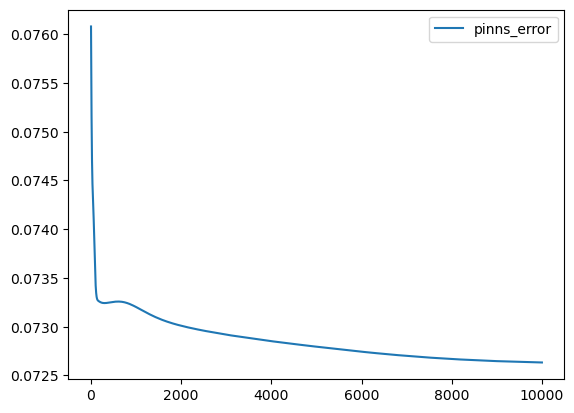

In [65]:
fig, ax = plt.subplots()
x_net = np.arange(0,10000,1)
ax.plot(x_net,error_pinns, label='pinns_error')
ax.legend()